<a href="https://colab.research.google.com/github/TipsyPanda/ComplexBridges/blob/main/IPMB_Anomaly_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Anomaly Detection
1. Data loading & basic EDA
2. Rolling-window feature engineering
3. Unsupervised anomaly detection (Isolation Forest)
4. Threshold calibration & evaluation (time-aware)
5. Minimal, stream-friendly scoring loop


## 1) Setup

In [2]:

# Install (if running elsewhere) and imports
# %pip install pandas numpy scikit-learn matplotlib scipy

import os
import json
import math
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import matplotlib.pyplot as plt

# Matplotlib defaults (no explicit colors)
plt.rcParams["figure.figsize"] = (10, 4)

from google.colab import drive
drive.mount('/content/drive/')
# Paths
DATA_PATH = "/content/drive/MyDrive/ComplexBridge_work/Data/"  # change if needed
ARTIFACT_DIR = "/content/drive/MyDrive/ComplexBridge_work/Artifacts/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 2) Load with **DatetimeIndex**

In [3]:
df = pd.read_pickle(DATA_PATH+"DF_BridgeData_cleaned.pkl")
print(type(df.index), df.index.min(), "→", df.index.max())
print("Columns:", df.columns.tolist())
print(df.shape)
df.head()


<class 'pandas.core.indexes.datetimes.DatetimeIndex'> 2025-10-10 12:00:00 → 2025-10-10 12:29:59.900000
Columns: ['bridge_id', 'span_id', 'sensor_id', 'sensor_type', 'value', 'unit', 'traffic_load_proxy', 'rule_threshold', 'anomaly', 'anomaly_type']
(90000, 10)


,bridge_id,span_id,sensor_id,sensor_type,value,unit,traffic_load_proxy,rule_threshold,anomaly,anomaly_type
timestamp,,,,,,,,,,
2025-10-10 12:00:00,BRIDGE_A01,SPAN_1,SG_001,strain_gauge,118.571847,microstrain,0.5,200.00,0,NaN
2025-10-10 12:00:00,BRIDGE_A01,SPAN_2,SG_002,strain_gauge,128.986727,microstrain,0.5,200.00,0,NaN
2025-10-10 12:00:00,BRIDGE_A01,SPAN_1,ACC_101,accelerometer_rms,0.020849,g,0.5,0.05,0,NaN
2025-10-10 12:00:00,BRIDGE_A01,SPAN_2,ACC_102,accelerometer_rms,0.015481,g,0.5,0.05,0,NaN
2025-10-10 12:00:00,BRIDGE_A01,SPAN_2,TMP_201,temperature,21.884280,C,0.5,35.00,0,NaN


## 3) Select a single stream for modeling (per `sensor_id`)

Working stream: strain_gauge SG_001 rows: 18000


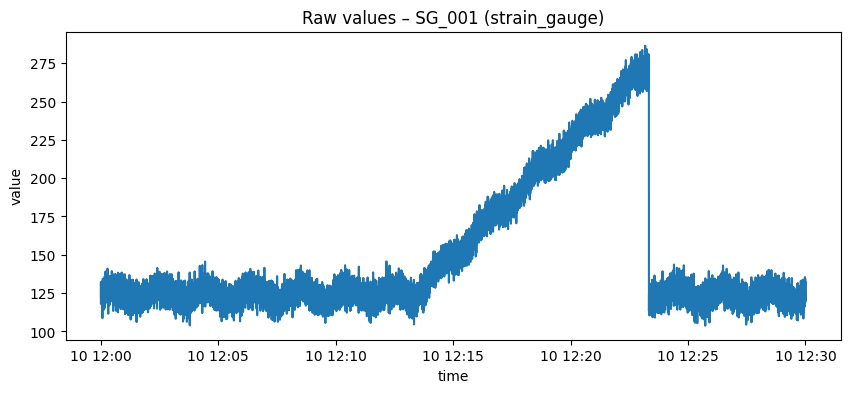

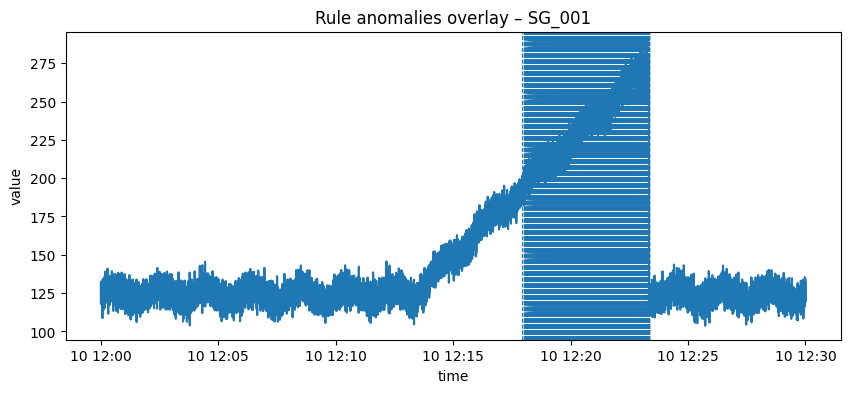

In [4]:

# Pick the first available sensor_id within the first sensor_type (customize as needed)
first_type = df['sensor_type'].dropna().unique()[0]
first_sensor = df.loc[df['sensor_type']==first_type, 'sensor_id'].dropna().unique()[0]

sub = df[(df['sensor_type']==first_type) & (df['sensor_id']==first_sensor)].copy()
sub = sub.sort_index()
print("Working stream:", first_type, first_sensor, "rows:", len(sub))

# Quick raw plot
fig = plt.figure()
plt.plot(sub.index, sub['value'])
plt.title(f"Raw values – {first_sensor} ({first_type})")
plt.xlabel("time"); plt.ylabel("value")
plt.show()

# Optional: overlay rule anomalies as vertical lines (if present)
if 'anomaly' in sub.columns:
    fig = plt.figure()
    plt.plot(sub.index, sub['value'])
    t_anom = sub.index[sub['anomaly']==1]
    for t in t_anom:
        plt.axvline(t, linestyle='--', linewidth=0.8)
    plt.title(f"Rule anomalies overlay – {first_sensor}")
    plt.xlabel("time"); plt.ylabel("value")
    plt.show()


## 4) Rolling-window feature engineering (uses index)

In [5]:

def infer_base_freq(idx: pd.DatetimeIndex) -> str:
    """Infer a base frequency string from a DatetimeIndex."""
    # Try pandas inference first
    guessed = pd.infer_freq(idx)
    if guessed is not None:
        return guessed
    # Fallback to median delta in milliseconds
    deltas = idx.to_series().diff().dropna().dt.total_seconds()
    if len(deltas) == 0:
        return "1S"
    ms = int(np.median(deltas) * 1000)
    ms = max(ms, 1)  # at least 1ms
    return f"{ms}L"  # 'L' = milliseconds

def make_rolling_features_index(ts: pd.DataFrame, window: str = '30s', step: str = '15s'):
    """
    Build rolling-window features assuming ts.index is a DatetimeIndex.
    Keeps time as the index; returns a DataFrame with 't_center' as a datetime column.
    """
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise TypeError("Expected a DatetimeIndex")
    ts = ts.sort_index()

    base_freq = infer_base_freq(ts.index)
    # Resample to fixed grid, forward-fill short gaps
    ts = ts.resample(base_freq).ffill()

    start, end = ts.index.min(), ts.index.max()
    out = []
    cur = start
    w = pd.to_timedelta(window)
    s = pd.to_timedelta(step)

    while cur + w <= end:
        win = ts.loc[cur:cur+w]
        if len(win) < 3:
            cur += s
            continue

        v = win['value'].values
        mean = float(np.mean(v))
        std = float(np.std(v, ddof=1)) if len(v) > 1 else 0.0
        rms = float(np.sqrt(np.mean(v**2)))
        p2p = float(np.max(v) - np.min(v))
        skew = float(pd.Series(v).skew()) if len(v) > 2 else 0.0
        kurt = float(pd.Series(v).kurtosis()) if len(v) > 3 else 0.0
        x = np.arange(len(v))
        slope = float(np.polyfit(x, v, 1)[0]) if len(v) > 1 else 0.0
        dv = np.diff(v)
        adiff_mean = float(np.mean(np.abs(dv))) if len(dv) else 0.0

        ctx = {}
        if 'traffic_load_proxy' in win.columns:
            tl = win['traffic_load_proxy'].values
            ctx['ctx_tl_mean'] = float(np.mean(tl))
            ctx['ctx_tl_std']  = float(np.std(tl, ddof=1)) if len(tl)>1 else 0.0
        if 'rule_threshold' in win.columns:
            ctx['ctx_rule_thr'] = float(np.median(win['rule_threshold']))

        label = None
        if 'anomaly' in win.columns:
            label = int((win['anomaly'] == 1).any())

        t_center = cur + w/2
        row = {
            't_center': t_center,
            'f_mean': mean, 'f_std': std, 'f_rms': rms, 'f_p2p': p2p,
            'f_skew': skew, 'f_kurt': kurt, 'f_slope': slope, 'f_adiff_mean': adiff_mean,
            **ctx
        }
        if label is not None:
            row['label_rule'] = label
        out.append(row)

        cur += s

    feats = pd.DataFrame(out).sort_values('t_center').reset_index(drop=True)
    return feats

feats = make_rolling_features_index(
    sub[['value','traffic_load_proxy','rule_threshold','anomaly']].copy(),
    window='30s', step='15s'
)
print(feats.shape)
feats.head()


(118, 13)


,t_center,f_mean,f_std,f_rms,f_p2p,f_skew,f_kurt,f_slope,f_adiff_mean,ctx_tl_mean,ctx_tl_std,ctx_rule_thr,label_rule
0,2025-10-10 12:00:15,126.658658,5.125310,126.761970,32.285725,-0.192222,0.193634,0.016330,5.402789,0.818113,0.154629,200.0,0
1,2025-10-10 12:00:30,127.476108,5.127490,127.578845,29.445191,-0.294861,0.166361,-0.000120,5.614491,0.949874,0.044363,200.0,0
2,2025-10-10 12:00:45,126.552713,5.147081,126.656992,25.979810,-0.050644,-0.171488,-0.009421,5.859216,0.818113,0.154629,200.0,0
3,2025-10-10 12:01:00,124.418993,5.043529,124.520835,27.749312,0.230286,0.226950,-0.017983,5.591404,0.500000,0.214149,200.0,0
4,2025-10-10 12:01:15,122.157222,5.010743,122.259605,29.463011,0.064628,0.247391,-0.007486,5.524889,0.181887,0.154629,200.0,0


## 5) Temporal split and scaling

In [6]:

cut = int(len(feats) * 0.7)
train = feats.iloc[:cut].copy()
test  = feats.iloc[cut:].copy()

feature_cols = [c for c in feats.columns if c.startswith('f_') or c.startswith('ctx_')]
label_col = 'label_rule' if 'label_rule' in feats.columns else None

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
Xs_tr = scaler.fit_transform(train[feature_cols])
Xs_te = scaler.transform(test[feature_cols])

import joblib
joblib.dump(scaler, os.path.join(ARTIFACT_DIR, "scaler.joblib"))
print("Saved:", os.path.join(ARTIFACT_DIR, "scaler.joblib"))


Saved: /content/drive/MyDrive/ComplexBridge_work/Artifacts/scaler.joblib


## 6) Isolation Forest (unsupervised)

In [7]:

from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=300,
    contamination='auto',
    random_state=42,
    n_jobs=-1
)
iso.fit(Xs_tr)

score_tr = iso.decision_function(Xs_tr)
score_te = iso.decision_function(Xs_te)

import joblib
joblib.dump(iso, os.path.join(ARTIFACT_DIR, "isoforest.pkl"))
print("Saved:", os.path.join(ARTIFACT_DIR, "isoforest.pkl"))


Saved: /content/drive/MyDrive/ComplexBridge_work/Artifacts/isoforest.pkl


## 7) Threshold calibration

In [8]:

import numpy as np, json

def pick_threshold(scores, quantile=0.005):
    return float(np.quantile(scores, quantile))

thr = pick_threshold(score_tr, quantile=0.005)
print("Chosen threshold:", thr)

with open(os.path.join(ARTIFACT_DIR, "threshold.json"), "w") as f:
    json.dump({"score_threshold": thr}, f)
print("Saved:", os.path.join(ARTIFACT_DIR, "threshold.json"))


Chosen threshold: -0.09627266609583994
Saved: /content/drive/MyDrive/ComplexBridge_work/Artifacts/threshold.json


## 8) Evaluation & visuals

AP: 1.000  Precision: 1.000  Recall: 0.417  F1: 0.588


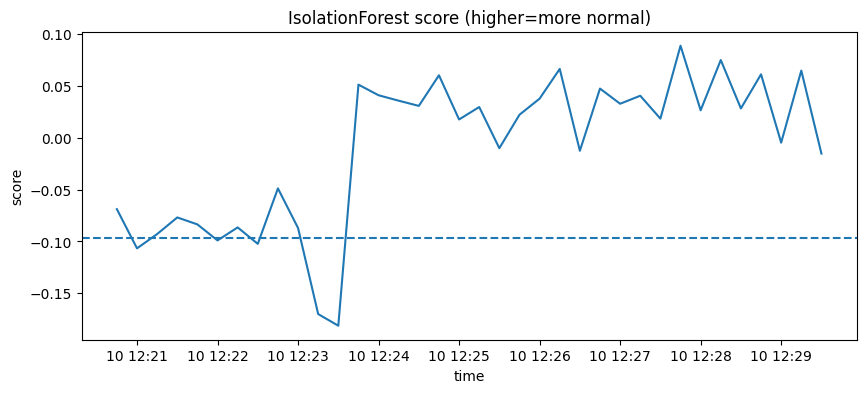

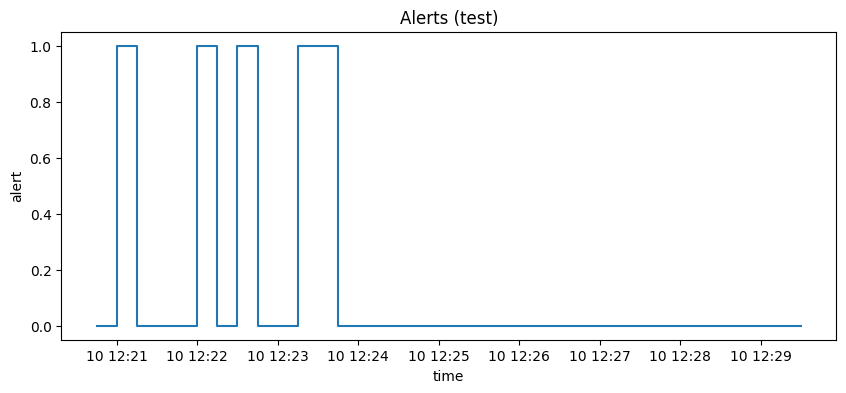

In [9]:

from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import matplotlib.pyplot as plt

alerts_te = (score_te < thr).astype(int)

if label_col is not None and label_col in test.columns:
    y_true = test[label_col].values
    anomaly_score_te = -score_te
    ap = average_precision_score(y_true, anomaly_score_te)
    p, r, f1, _ = precision_recall_fscore_support(y_true, alerts_te, average='binary', zero_division=0)
    print(f"AP: {ap:.3f}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f1:.3f}")
else:
    print("No labels available; showing score plots only.")

# Score timeline
fig = plt.figure()
plt.plot(test['t_center'], score_te)
plt.axhline(thr, linestyle='--')
plt.title("IsolationForest score (higher=more normal)")
plt.xlabel("time"); plt.ylabel("score")
plt.show()

# Alerts (binary)
fig = plt.figure()
plt.plot(test['t_center'], alerts_te, drawstyle='steps-post')
plt.title("Alerts (test)")
plt.xlabel("time"); plt.ylabel("alert")
plt.show()


## 9) Mini scoring loop (DatetimeIndex pipeline)

In [10]:

events = []
for t, s, a in zip(test['t_center'], score_te, (score_te < thr).astype(int)):
    if a == 1:
        events.append({"t": str(t), "event": "ALERT", "score": float(s)})
len(events), events[:5]


(5,
 [{'t': '2025-10-10 12:21:00',
   'event': 'ALERT',
   'score': -0.10662848740170594},
  {'t': '2025-10-10 12:22:00',
   'event': 'ALERT',
   'score': -0.09900459889421032},
  {'t': '2025-10-10 12:22:30',
   'event': 'ALERT',
   'score': -0.10229669810224928},
  {'t': '2025-10-10 12:23:15',
   'event': 'ALERT',
   'score': -0.16990673693912628},
  {'t': '2025-10-10 12:23:30',
   'event': 'ALERT',
   'score': -0.18114191368111987}])

## 10) Notes & next steps
- Resampling is driven by the DatetimeIndex (no `timestamp` column).
- Extend features with FFT band powers for vibration streams.
- Consider per-sensor models for tighter boundaries.
- Add drift monitoring with rolling median/MAD of scores.
- Wire artifacts into a Streamlit dashboard.
